<a href="https://colab.research.google.com/github/fjadidi2001/DecompDenoise/blob/main/DD_Feb12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries


In [2]:
import os
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.linalg import svd

# Step 2: Synthetic Data Generation


In [3]:
def add_gaussian_noise(image, mean=0, sigma=25):
    """Add Gaussian noise to an image."""
    noisy = image + np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    return np.clip(noisy, 0, 255)

def add_salt_pepper_noise(image, prob=0.05):
    """Add salt-and-pepper noise to an image."""
    return (random_noise(image, mode='s&p', amount=prob) * 255).astype(np.uint8)

def add_poisson_noise(image):
    """Add Poisson noise to an image."""
    return (random_noise(image, mode='poisson') * 255).astype(np.uint8)

# Step 3: Preprocessing Pipeline


In [4]:
def preprocess_image(image_path, target_size=(256, 256)):
    """Full preprocessing pipeline: load, resize, and add noise."""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Resize to target size
    image = cv2.resize(image, target_size)

    # Apply synthetic noise
    noisy_gaussian = add_gaussian_noise(image)
    noisy_salt_pepper = add_salt_pepper_noise(image)
    noisy_poisson = add_poisson_noise(image)

    return {
        "original": image,
        "noisy_gaussian": noisy_gaussian,
        "noisy_salt_pepper": noisy_salt_pepper,
        "noisy_poisson": noisy_poisson
    }

# Step 4: Visualization Function


In [5]:
def display_images(images_dict):
    """Display the original and noisy images with titles."""
    plt.figure(figsize=(15, 10))

    # Plot original image
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(images_dict["original"], cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    # Plot noisy images
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(images_dict["noisy_gaussian"], cv2.COLOR_BGR2RGB))
    plt.title("Gaussian Noise")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(images_dict["noisy_salt_pepper"], cv2.COLOR_BGR2RGB))
    plt.title("Salt-and-Pepper Noise")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(images_dict["noisy_poisson"], cv2.COLOR_BGR2RGB))
    plt.title("Poisson Noise")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Step 5: Enhanced Preprocessing


In [6]:
def normalize_image(image):
    """Normalize image to 0-255 range."""
    normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized.astype(np.uint8)

def anscombe_transform(image):
    """Apply Anscombe transform with proper normalization."""
    float_image = image.astype(float)
    transformed = 2.0 * np.sqrt(float_image + 3.0/8.0)
    return normalize_image(transformed)

def create_gabor_filters(num_filters=8):
    """Create a bank of Gabor filters with improved parameters."""
    filters = []
    ksize = 31
    sigma = 4.0
    lambda_min = 4.0

    for theta in np.arange(0, np.pi, np.pi/num_filters):
        for lambda_val in [lambda_min, lambda_min*2]:
            kernel = cv2.getGaborKernel(
                (ksize, ksize),
                sigma=sigma,
                theta=theta,
                lambd=lambda_val,
                gamma=0.5,
                psi=0,
                ktype=cv2.CV_32F
            )
            kernel /= np.sum(np.abs(kernel))  # Normalize kernel
            filters.append(kernel)

    return filters

def apply_gabor_filters(image, kernels):
    """Apply Gabor filters with proper normalization and magnitude computation."""
    if len(image.shape) == 3:  # Convert to grayscale if color image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    gray = gray.astype(np.float32)  # Convert to float32
    magnitude = np.zeros_like(gray)  # Initialize accumulator for magnitude

    for kernel in kernels:
        filtered = cv2.filter2D(gray, cv2.CV_32F, kernel)
        magnitude += np.abs(filtered)

    return normalize_image(magnitude)  # Normalize the magnitude

# Step 6: Fourier and Low-Rank Decomposition


In [7]:
def fourier_decomposition(image, threshold_factor=0.1):
    """Decompose image into structural and textural components using Fourier transform."""
    if len(image.shape) == 3:  # Handle color images
        structural = np.zeros_like(image)
        textural = np.zeros_like(image)

        for channel in range(3):
            s, t = fourier_decomposition(image[:,:,channel], threshold_factor)
            structural[:,:,channel] = s
            textural[:,:,channel] = t

        return structural, textural

    # Process single channel
    f_transform = fftshift(fft2(image))
    magnitude_spectrum = np.abs(f_transform)

    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    radius = int(min(rows, cols) * threshold_factor)

    y, x = np.ogrid[-center_row:rows-center_row, -center_col:cols-center_col]
    mask = x*x + y*y <= radius*radius

    structural_freq = f_transform.copy()
    textural_freq = f_transform.copy()

    structural_freq[~mask] = 0
    textural_freq[mask] = 0

    structural = np.real(ifft2(ifftshift(structural_freq)))
    textural = np.real(ifft2(ifftshift(textural_freq)))

    return structural.astype(np.uint8), textural.astype(np.uint8)

def low_rank_decomposition(image, rank=10):
    """Perform low-rank matrix decomposition using SVD."""
    if len(image.shape) == 3:  # Handle color images
        low_rank = np.zeros_like(image, dtype=float)
        sparse = np.zeros_like(image, dtype=float)

        for channel in range(3):
            lr, sp = low_rank_decomposition(image[:,:,channel], rank)
            low_rank[:,:,channel] = lr
            sparse[:,:,channel] = sp

        return normalize_image(low_rank), normalize_image(sparse)

    # Process single channel
    U, s, Vt = svd(image.astype(float), full_matrices=False)
    s_truncated = np.zeros_like(s)
    s_truncated[:rank] = s[:rank]

    low_rank = U @ np.diag(s_truncated) @ Vt
    sparse = image.astype(float) - low_rank

    return normalize_image(low_rank), normalize_image(sparse)

# Step 7: Advanced Denoising


In [8]:
def advanced_denoising(image, noise_level=0.1):
    """Perform advanced denoising using combined decomposition techniques."""
    image_float = image.astype(float)  # Convert to float for processing

    # Apply decompositions
    structural, textural = fourier_decomposition(image, threshold_factor=0.1)
    low_rank_comp, sparse_comp = low_rank_decomposition(image, rank=20)

    # Combine components for final denoised image
    if len(image.shape) == 3:
        denoised = np.zeros_like(image_float)
        for channel in range(3):
            denoised[:,:,channel] = (
                0.7 * structural[:,:,channel] +
                0.3 * low_rank_comp[:,:,channel]
            )
    else:
        denoised = 0.7 * structural + 0.3 * low_rank_comp

    return {
        'denoised': normalize_image(denoised),
        'structural': structural,
        'textural': textural,
        'low_rank': low_rank_comp,
        'sparse': sparse_comp
    }

# Step 8: Display Decomposition Results


In [9]:
def display_decomposition_results(results):
    """Display decomposition results."""
    plt.figure(figsize=(15, 10))

    titles = [
        'Original', 'Structural Component', 'Textural Component',
        'Low-rank Component', 'Sparse Component', 'Denoised Result'
    ]

    images = [
        results['original'],
        results['structural'],
        results['textural'],
        results['low_rank'],
        results['sparse'],
        results['denoised']
    ]

    for idx, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(2, 3, idx + 1)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Step 9: Example Usage


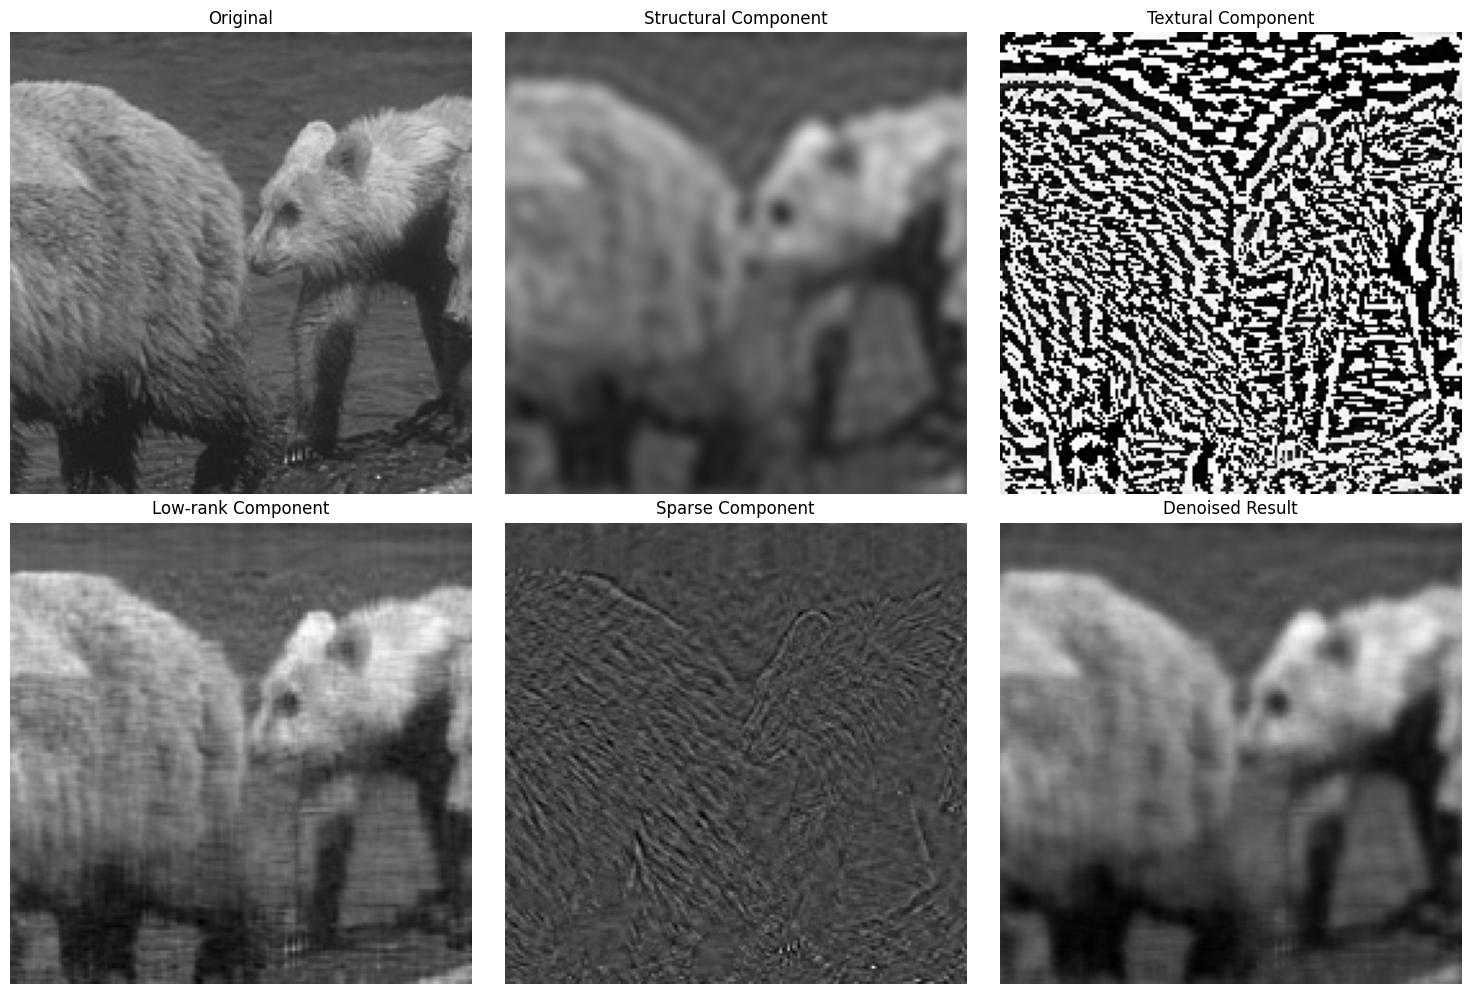

In [12]:
if __name__ == "__main__":
    try:
        # Load image
        image_path = "test_001.png"
        noisy_image = cv2.imread(image_path)

        if noisy_image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        # Perform decomposition and denoising
        results = advanced_denoising(noisy_image)
        results['original'] = noisy_image

        # Display results
        display_decomposition_results(results)

    except Exception as e:
        print(f"An error occurred: {e}")

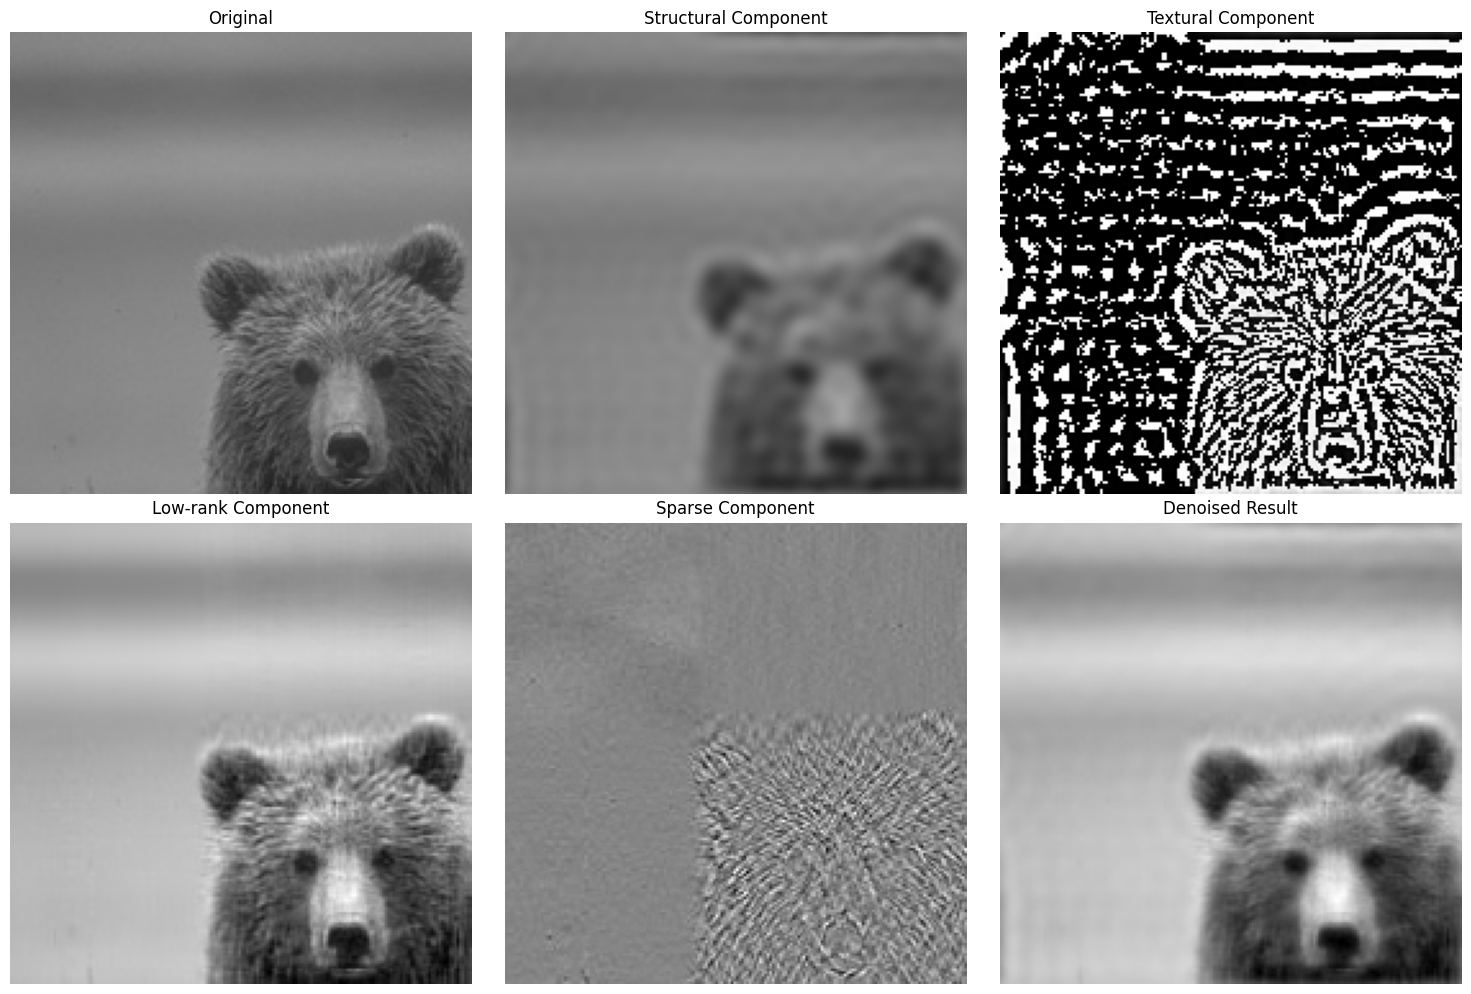

In [13]:
if __name__ == "__main__":
    try:
        # Load image
        image_path = "test_002.png"
        noisy_image = cv2.imread(image_path)

        if noisy_image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        # Perform decomposition and denoising
        results = advanced_denoising(noisy_image)
        results['original'] = noisy_image

        # Display results
        display_decomposition_results(results)

    except Exception as e:
        print(f"An error occurred: {e}")

# added new denoise image

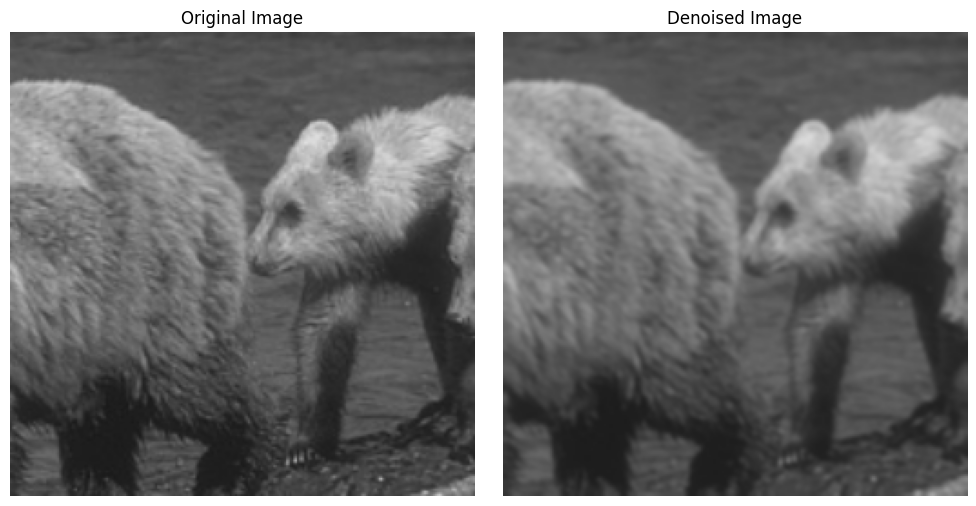

In [15]:
def denoise_image(image):
    """Apply denoising to the image."""
    # Apply Gaussian blur
    denoised = cv2.GaussianBlur(image, (5, 5), 0)
    return denoised

# Example usage
if __name__ == "__main__":
    image_path = "test_001.png"  # Replace with the correct path if needed
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Resize to target size
    image = cv2.resize(image, (256, 256))

    # Apply denoising
    denoised_image = denoise_image(image)

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
    plt.title("Denoised Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()